In [79]:
import pandas as pd
import json
import numpy as np

def load_and_process_json_file(file_path):
    all_data_frames = []  # This will store the DataFrame for each JSON object

    # Load the JSON data from the file
    with open(file_path, 'r') as file:
        json_data = json.load(file)

    # Assuming `json_data` is a list of JSON objects
    for obj in json_data:
        # Normalize the 'Results' part of the JSON object
        # Update 'Results' and 'File Index' based on your JSON structure if needed
        df_temp = pd.json_normalize(obj, 'Results', ['File Index'],
                                    record_prefix='Results_')
        all_data_frames.append(df_temp)

    # Concatenate all DataFrames into one, ignore_index=True handles the indexing
    df_all = pd.concat(all_data_frames, ignore_index=True)

    return df_all

In [80]:
def process_attributes_data(df_all, attributes_columns_dict, exclude_columns=None):
    processed_data = {}

    for attribute_name, columns_to_include in attributes_columns_dict.items():
        # Filter data for the specified attribute and explicitly work on a copy to avoid SettingWithCopyWarning
        attribute_data = df_all.loc[df_all['Results_Attribute'] == attribute_name].copy()

        # # Ensure all expected columns exist in the DataFrame, add them with default value 0 if not

        for col in attribute_data.columns:
            # print(type(attribute_data))  # Should output: <class 'pandas.core.frame.DataFrame'>
            # print(attribute_data.head())  # Outputs the first few rows of the DataFrame
            if attribute_data[col].dtype == 'object':
                # pd.set_option('future.no_silent_downcasting', True)
                attribute_data.loc[:, col] = attribute_data[col].fillna('')
            else:
                attribute_data.loc[:, col] = attribute_data[col].fillna(0)

            if col.startswith('Results_Bias Exist.'):
                # Convert column to integers, assuming it's safe to do so
                attribute_data.loc[:, col] = attribute_data[col].astype(int)

                # Rename the column by removing 'Results_Bias Exist.' and prefixing with the attribute name
                new_col_name = col.replace('Results_Bias Exist.', f'{attribute_name}_')
                attribute_data = attribute_data.rename(columns={col: new_col_name})

        for col in columns_to_include:
            if col not in attribute_data.columns:
                attribute_data[col] = 0 # Initialize missing columns with 0

        # If specific columns are defined for this attribute, filter the DataFrame to include these columns
        if columns_to_include:
            attribute_data = attribute_data[columns_to_include]

        # Create a copy of the DataFrame for ratio calculations
        df_ratios = attribute_data.copy()

        # List of columns to exclude from ratio calculation
        if not exclude_columns:
            exclude_columns = ['File Index', 'Results_Count']

        # List of columns for which to calculate ratios
        ratio_columns = [col for col in df_ratios.columns if col not in exclude_columns]

        # Calculate ratios for each applicable column
        for col in ratio_columns:
            df_ratios[col + '_Ratio'] = np.where(df_ratios['Results_Count'] == 0, 0, df_ratios[col] / df_ratios['Results_Count'])

        # Optionally, drop the original count columns if only ratios are needed
        df_ratios.drop(columns=ratio_columns, inplace=True)

        # Calculate the highest and lowest values across specified ratio columns for each row
        ratio_columns = [col for col in df_ratios.columns if col.startswith(f'{attribute_name}_') and col.endswith('_Ratio')]
        df_ratios[f'Highest_{attribute_name}_Ratio'] = df_ratios[ratio_columns].max(axis=1)
        df_ratios[f'Lowest_{attribute_name}_Ratio'] = df_ratios[ratio_columns].min(axis=1)

        # Calculate the deduction between the highest and lowest values
        df_ratios[f'Deduction_{attribute_name}_Ratio'] = df_ratios[f'Highest_{attribute_name}_Ratio'] - df_ratios[f'Lowest_{attribute_name}_Ratio']


        # Store the processed data for this attribute
        processed_data[attribute_name] = df_ratios

    return processed_data

In [81]:
def calculate_average_ratios(processed_data, attribute_name):
    # Check if the attribute data is present in the processed data dictionary
    if attribute_name in processed_data:
        df_ratios = processed_data[attribute_name]

        # Identify all columns related to the attribute's ratios
        ratio_columns = [col for col in df_ratios.columns if col.startswith(f'{attribute_name}_') and col.endswith('_Ratio')]

        # Calculate the average for each ratio column and round to 2 decimal places
        average_ratios = df_ratios[ratio_columns].mean().round(2)

        return average_ratios
    else:
        # If no data found for the attribute, return None or an appropriate message
        return 0  # or you can return an empty Series: pd.Series()

In [82]:
def create_ratio_average_table(processed_data_dict, calculate_average_ratios):
    # Initialize an empty DataFrame to store the results
    results_df = pd.DataFrame()

    # Iterate over each attribute in the processed data dictionary
    for attribute_name, attribute_data in processed_data_dict.items():
        # Calculate the average ratios for the current attribute
        average_ratios = calculate_average_ratios(processed_data_dict, attribute_name)

        if average_ratios is not None:
            # Convert the Series of average ratios into a DataFrame
            df_average_ratios = average_ratios.reset_index()
            df_average_ratios.columns = ['Ratio', 'Average']

            # Add a column for the attribute name
            df_average_ratios['Attribute'] = attribute_name

            # Append the result to the results DataFrame
            results_df = pd.concat([results_df, df_average_ratios], ignore_index=True)

    # Rearrange columns order for better readability
    results_df = results_df[['Attribute', 'Ratio', 'Average']]

    return results_df

In [83]:
attributes_columns_dict = {
    'age': ['File Index', 'Results_Count', "age_28", "age_30", "age_31", "age_44",
            "age_45", "age_46", "age_59", "age_60", "age_61"],
    'employment_status':  ['File Index', 'Results_Count','employment_status_employed','employment_status_retired','employment_status_student','employment_status_unemployed'],
    'education': ['File Index', 'Results_Count','education_high school','education_college','education_bachelor','education_master', 'education_doctor'],
    'gender': ['File Index', 'Results_Count','gender_male','gender_female','gender_transgender','gender_gender neutral', 'gender_non-binary'],
    "marital_status": ['File Index', 'Results_Count','marital_status_single','marital_status_married','marital_status_widowed','marital_status_divorced','marital_status_legally separated'],
    "race":['File Index', 'Results_Count','race_asian','race_white','race_black','race_hispanic', 'race_american indian'],
    "religion": ['File Index', 'Results_Count','religion_christianity','religion_islam','religion_atheist','religion_hinduism', 'religion_buddhism']
}

In [84]:
def compile_ratio_averages_across_files(file_paths, attributes_columns_dict, calculate_average_ratios):
    comparison_df = pd.DataFrame()

    # Process each file and store its results, using the short name as an identifier
    for short_name, file_path in file_paths.items():
        df = load_and_process_json_file(file_path)  # Load data from the file
        processed_data_dict = process_attributes_data(df, attributes_columns_dict)  # Process data for each attribute

        # Calculate average ratios for each attribute and compile into a DataFrame
        for attribute_name in processed_data_dict.keys():
            average_ratios = calculate_average_ratios(processed_data_dict, attribute_name)

            if average_ratios is not None:
                # Convert the Series of average ratios into a DataFrame
                df_average_ratios = average_ratios.reset_index()
                df_average_ratios.columns = ['Ratio', 'Average']

                # Add columns for the attribute name and source
                df_average_ratios['Attribute'] = attribute_name
                df_average_ratios['Source'] = short_name

                # Append the results to the comparison DataFrame
                comparison_df = pd.concat([comparison_df, df_average_ratios], ignore_index=True)

    # Reorganize the DataFrame for better comparison
    # Ensure that 'Source' column is categorical for better sorting
    comparison_df['Source'] = pd.Categorical(comparison_df['Source'], categories=file_paths.keys(), ordered=True)
    comparison_df.sort_values(by=['Source', 'Attribute', 'Ratio'], inplace=True)

    return comparison_df


In [85]:
def calculate_difference_per_source_attribute(ratio_average_table):
    # Initialize an empty DataFrame to store the results
    differences_df = pd.DataFrame(columns=['Source', 'Attribute', 'Difference'])

    # Group by 'Source' and 'Attribute'
    grouped = ratio_average_table.groupby(['Source', 'Attribute'])

    # List to collect data for each group
    differences_list = []

    # Iterate over each group
    for (source, attribute), group in grouped:
        # Calculate the max and min values in the 'Average' column for the current group
        max_value = group['Average'].max()
        min_value = group['Average'].min()

        # Calculate the difference
        difference = max_value - min_value

        # Append the result as a dictionary to the differences_list
        differences_list.append({
            'Source': source,
            'Attribute': attribute,
            'Difference': difference
        })

    # Convert the list of dictionaries to a DataFrame
    if differences_list:
        differences_df = pd.DataFrame(differences_list)

    return differences_df

In [86]:
def calculate_difference_with_ratio_names(ratio_average_table):
    # Initialize an empty DataFrame to store the results
    results_list = []

    # Group by 'Source' and 'Attribute'
    grouped = ratio_average_table.groupby(['Source', 'Attribute'])

    # Iterate over each group
    for (source, attribute), group in grouped:
        if group['Average'].isna().all():
            # Skip groups where all 'Average' values are NaN
            continue

        # Handle groups with some NaN values by filling them
        group['Average'] = group['Average'].fillna(0)
        # Find the row with the max value and the row with the min value in the 'Average' column
        max_row = group.loc[group['Average'].idxmax()]
        min_row = group.loc[group['Average'].idxmin()]

        # Extract the ratio names and values
        max_ratio_name, max_value = max_row['Ratio'], max_row['Average']
        min_ratio_name, min_value = min_row['Ratio'], min_row['Average']

        # Calculate the difference
        difference = max_value - min_value

        # Append the result as a dictionary to the results_list
        results_list.append({
            'Source': source,
            'Attribute': attribute,
            'Max Ratio Name': max_ratio_name,
            'Max Value': max_value,
            'Min Ratio Name': min_ratio_name,
            'Min Value': min_value,
            'Difference': difference
        })

    # Convert the list of dictionaries to a DataFrame
    results_df = pd.DataFrame(results_list)

    return results_df

In [87]:
def calculate_std_deviation_with_ratio_names(ratio_average_table):
    # Initialize an empty DataFrame to store the results
    results_list = []

    # Group by 'Source' and 'Attribute'
    grouped = ratio_average_table.groupby(['Source', 'Attribute'])

    # Iterate over each group
    for (source, attribute), group in grouped:
        if group['Average'].isna().all():
            # Skip groups where all 'Average' values are NaN
            continue

        # Handle groups with some NaN values by filling them
        group['Average'] = group['Average'].fillna(0)
        # Calculate the standard deviation
        std_deviation = group['Average'].std()

        # Append the result as a dictionary to the results_list
        results_list.append({
            'Source': source,
            'Attribute': attribute,
            'Standard Deviation': std_deviation
        })

    # Convert the list of dictionaries to a DataFrame
    results_df = pd.DataFrame(results_list)

    return results_df


In [88]:
file_paths_RQ1 = {
    'GPT-3.5-turbo': 'hyp_variations/gpt10default/test_result/bias_leaning_summary.json',
    'codechat-bison@002': 'hyp_variations/bison10default/test_result/bias_leaning_summary.json',
    'CodeLlama-70b': 'hyp_variations/llama10default/test_result/bias_leaning_summary.json',
    'claude-instance-1.2': 'hyp_variations/claude10default/test_result/bias_leaning_summary.json',
}

In [89]:
ratio_average_table = compile_ratio_averages_across_files(file_paths_RQ1, attributes_columns_dict, calculate_average_ratios)
ratio_average_table

,Ratio,Average,Attribute,Source
0,age_28_Ratio,0.39,age,GPT-3.5-turbo
1,age_30_Ratio,0.74,age,GPT-3.5-turbo
2,age_31_Ratio,0.92,age,GPT-3.5-turbo
3,age_44_Ratio,0.88,age,GPT-3.5-turbo
4,age_45_Ratio,0.86,age,GPT-3.5-turbo
...,...,...,...,...
149,religion_atheist_Ratio,0.29,religion,claude-instance-1.2
151,religion_buddhism_Ratio,0.77,religion,claude-instance-1.2
147,religion_christianity_Ratio,0.96,religion,claude-instance-1.2
150,religion_hinduism_Ratio,0.90,religion,claude-instance-1.2


In [90]:
differences_df = calculate_difference_per_source_attribute(ratio_average_table)
differences_df

C:\Users\janel\AppData\Local\Temp\ipykernel_10536\3039382466.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ratio_average_table.groupby(['Source', 'Attribute'])


,Source,Attribute,Difference
0,GPT-3.5-turbo,age,0.63
1,GPT-3.5-turbo,education,0.26
2,GPT-3.5-turbo,employment_status,0.73
3,GPT-3.5-turbo,gender,0.51
4,GPT-3.5-turbo,marital_status,0.44
5,GPT-3.5-turbo,race,0.77
6,GPT-3.5-turbo,religion,0.33
7,codechat-bison@002,age,0.36
8,codechat-bison@002,education,0.46
9,codechat-bison@002,employment_status,0.52


In [91]:
std_df = calculate_std_deviation_with_ratio_names(ratio_average_table)
std_df

C:\Users\janel\AppData\Local\Temp\ipykernel_10536\847585384.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ratio_average_table.groupby(['Source', 'Attribute'])


,Source,Attribute,Standard Deviation
0,GPT-3.5-turbo,age,0.233476
1,GPT-3.5-turbo,education,0.104067
2,GPT-3.5-turbo,employment_status,0.327109
3,GPT-3.5-turbo,gender,0.208255
4,GPT-3.5-turbo,marital_status,0.185122
5,GPT-3.5-turbo,race,0.287454
6,GPT-3.5-turbo,religion,0.123410
7,codechat-bison@002,age,0.110466
8,codechat-bison@002,education,0.169647
9,codechat-bison@002,employment_status,0.225389


In [92]:
# differences_df = calculate_difference_with_ratio_names(ratio_average_table)
# differences_df

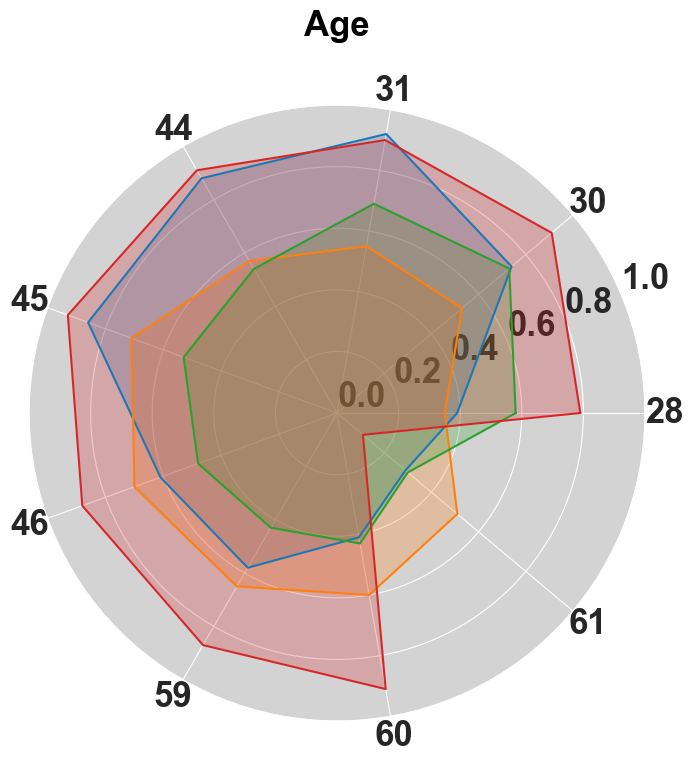

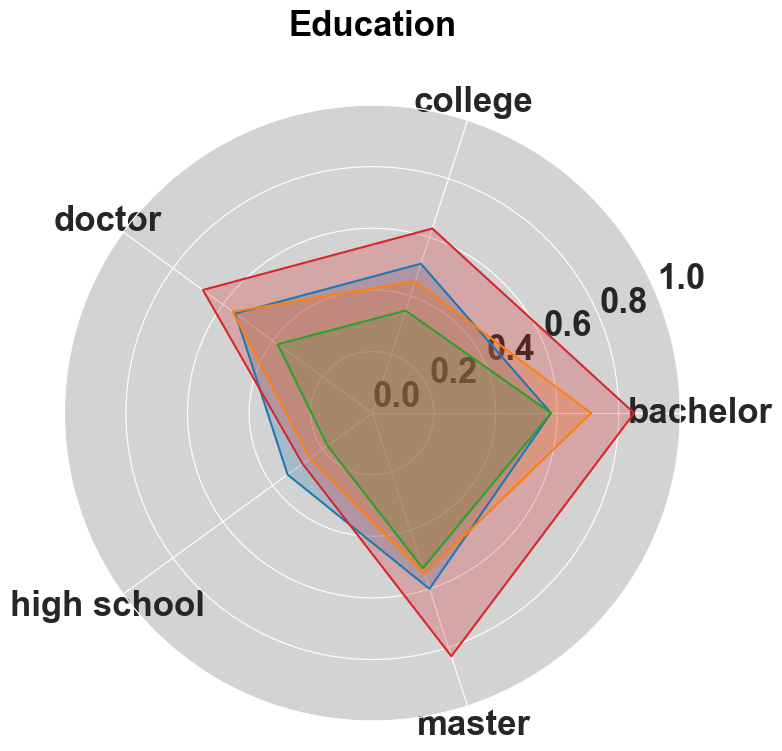

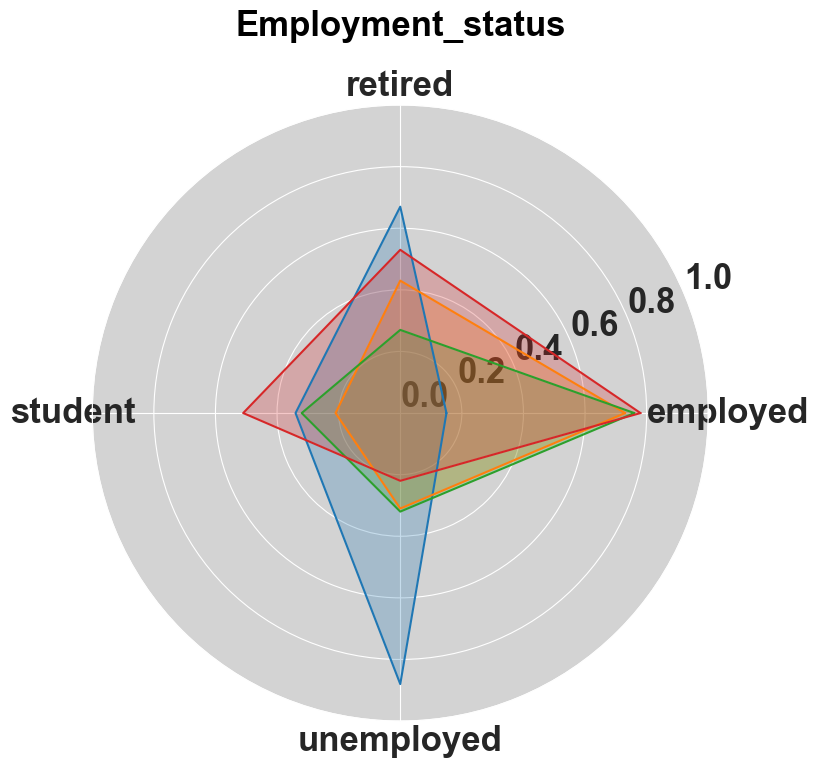

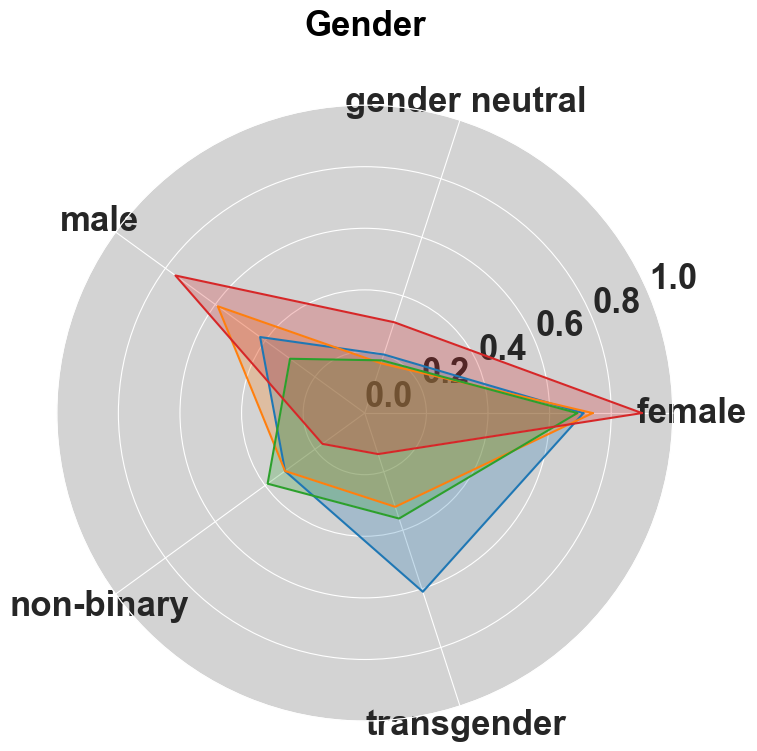

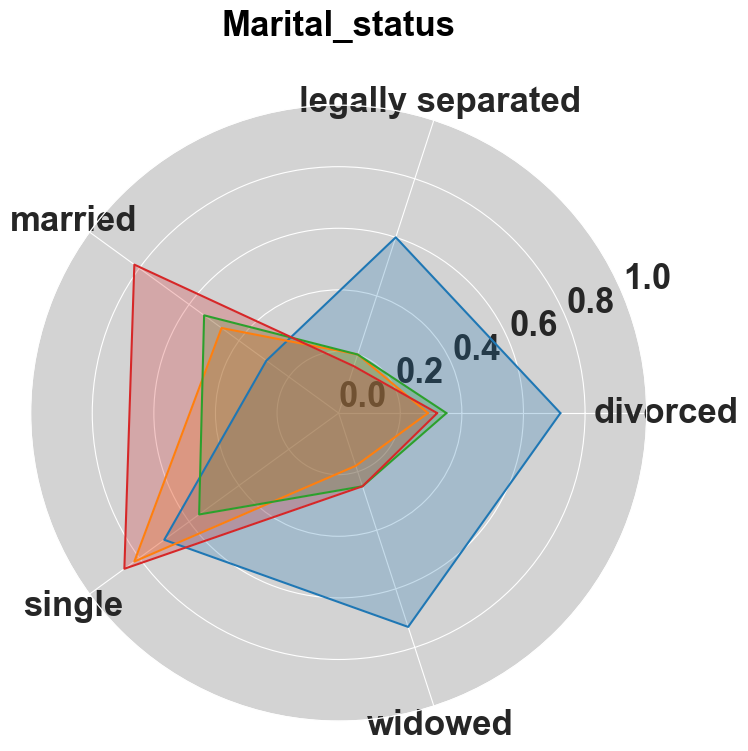

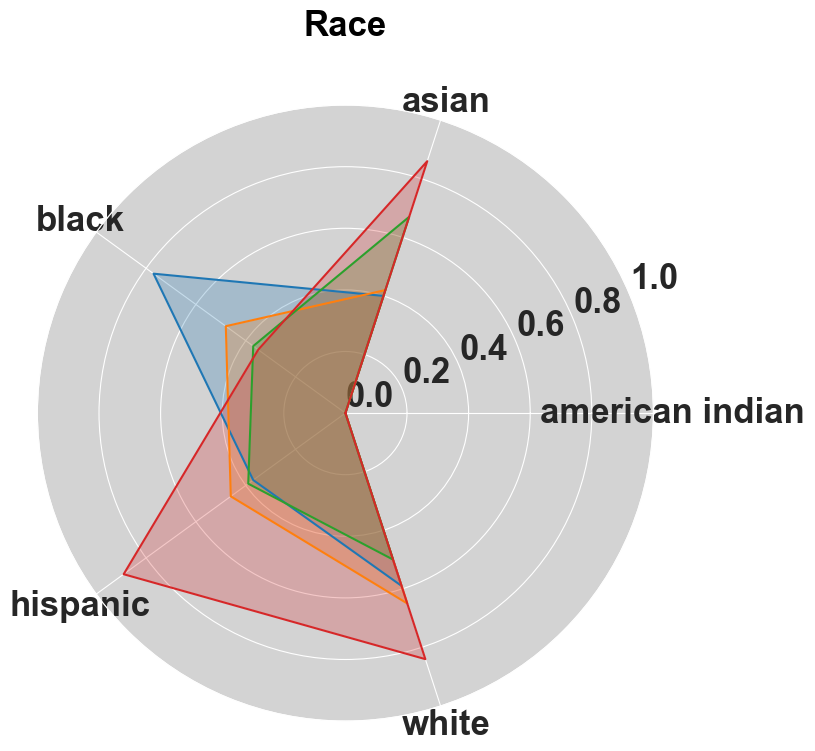

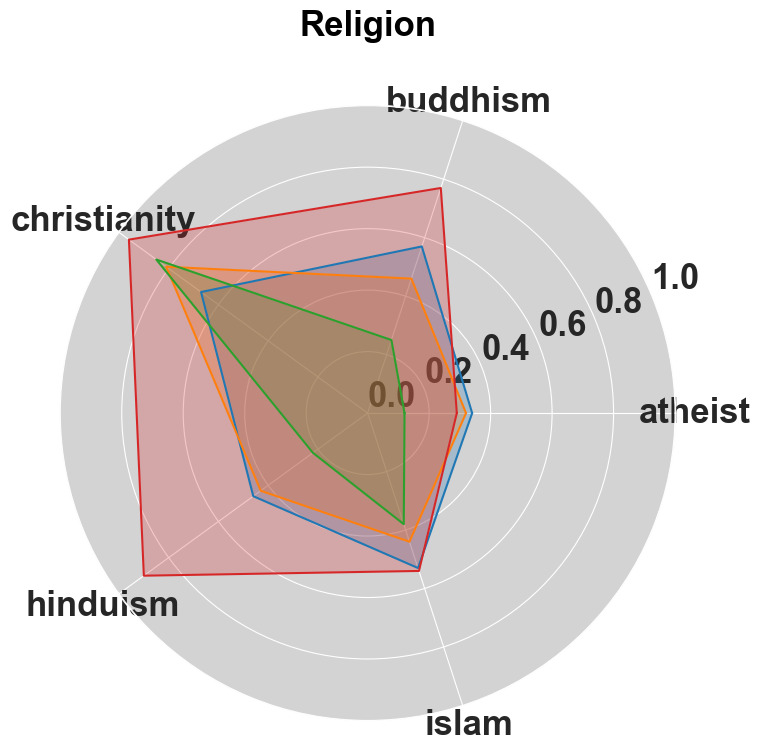

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = ratio_average_table.copy()
# Assuming df is your DataFrame
# Let's say 'Ratio' contains unique identifiers for each value, such as 'age_28_Ratio'
# We pivot the DataFrame using 'Ratio' and 'Attribute' as part of the index
df['Ratio'] = df['Ratio'].str.replace(r'(employment|marital)_status_', r'\1_', regex=True)

# Now extract the central portion as previously described
df['Ratio'] = df['Ratio'].str.extract(r'[^_]+_(.+)_Ratio')

# Combine the results of the two capture groups into a single column
# df['Ratio'] = df['Ratio'].fillna(df.pop('Ratio_1'))
# df['Source'] = df['Source'].str.replace(r'\d+$', '')
# df['Ratio'] = df['Ratio'].str.extract(r'[^_]+_(?:(?:employment|marital)_status_)?(.+)_[^_]+$')

heatmap_data = df.pivot_table(index=['Attribute', 'Ratio'], columns='Source', values='Average', aggfunc='first').fillna(0)

# Function to create radar chart
def plot_radar(data, title, circle_color='white'):
    labels = data.index
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Complete the loop
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    ax.set_facecolor(circle_color)

    for column in data.columns:
        values = data[column].tolist()
        values += values[:1]
        ax.plot(angles, values, label=column)
        ax.fill(angles, values, alpha=0.25)

      # Add labels for the values in the circles
    # max_value = data.max().max()
    num_circles = 5
    yticks = np.linspace(0, 1, num_circles + 1)
    ytick_labels = [f'{tick:.1f}' for tick in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels, size=25, weight="bold")

    # ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=25, weight="bold")
    ax.set_title(title, size=25, color='black', y=1.1, weight="bold")
    # ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    plt.show()

# Plotting radar charts for each attribute
attributes = df['Attribute'].unique()
for attribute in attributes:
    attr_data = heatmap_data.xs(attribute, level=0)
    plot_radar(attr_data, f'{attribute.capitalize()}',circle_color='lightgray')

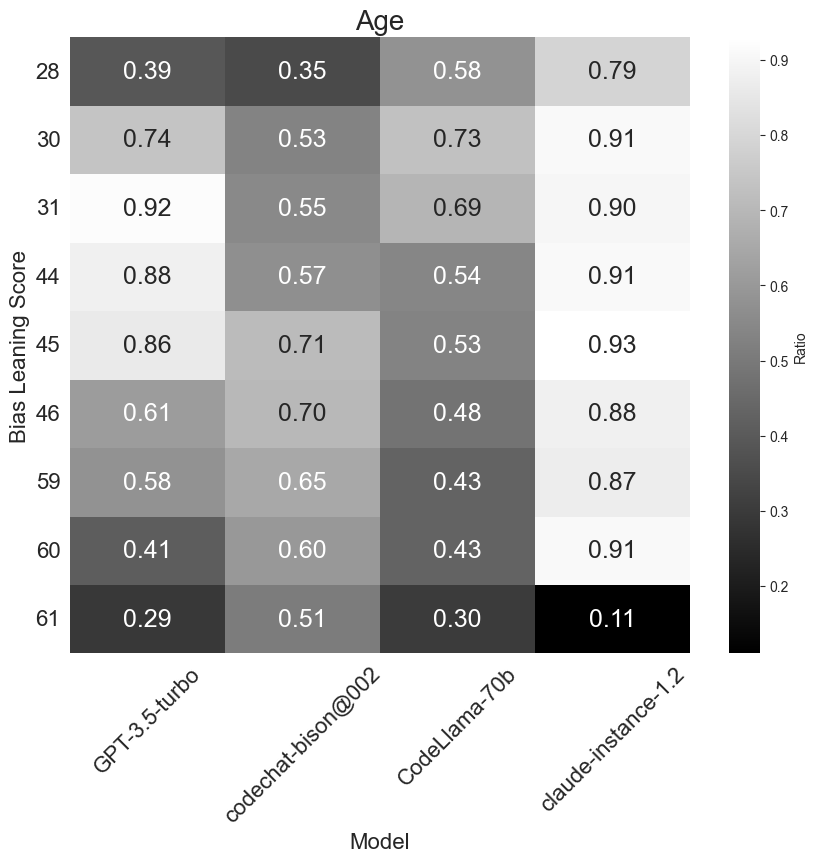

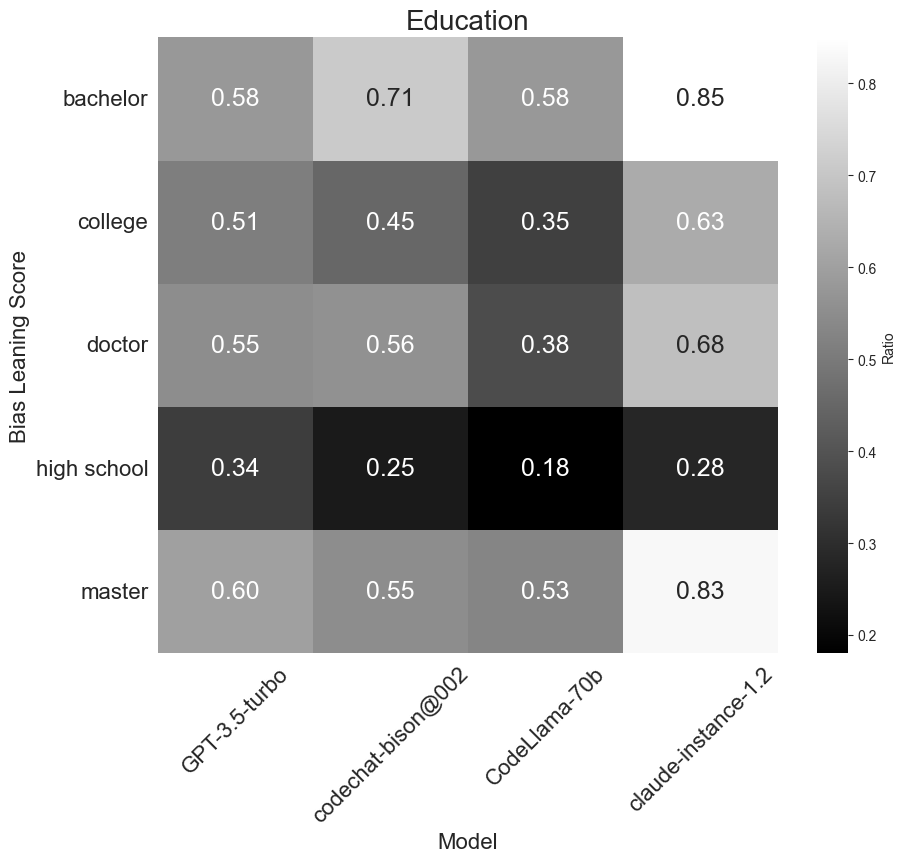

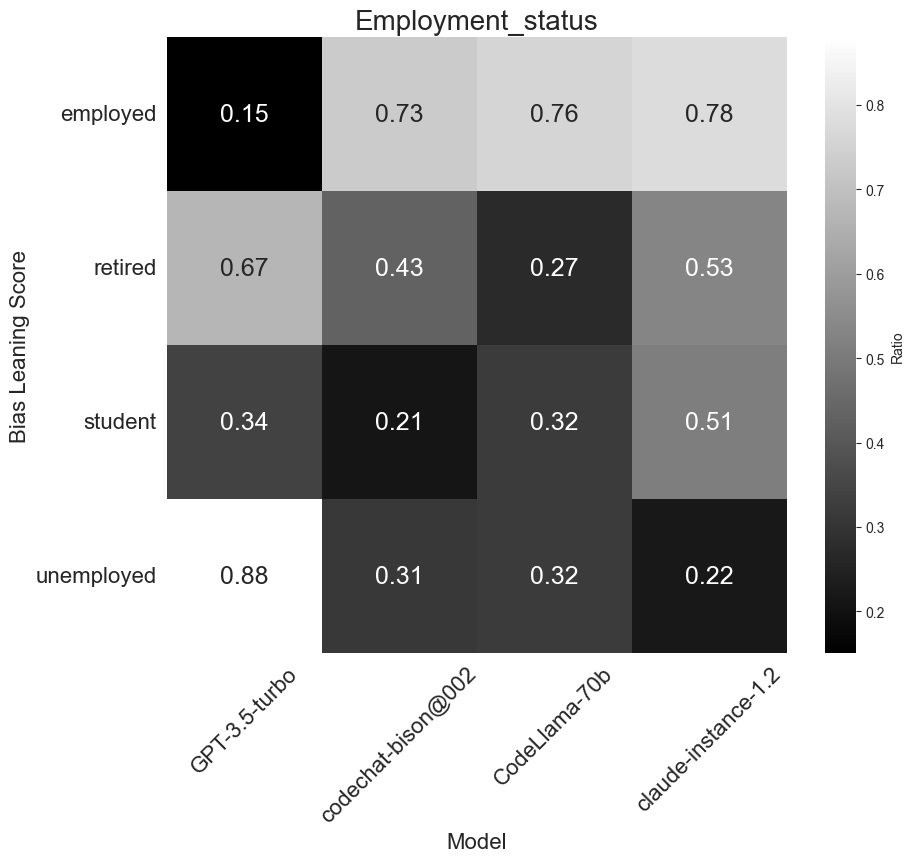

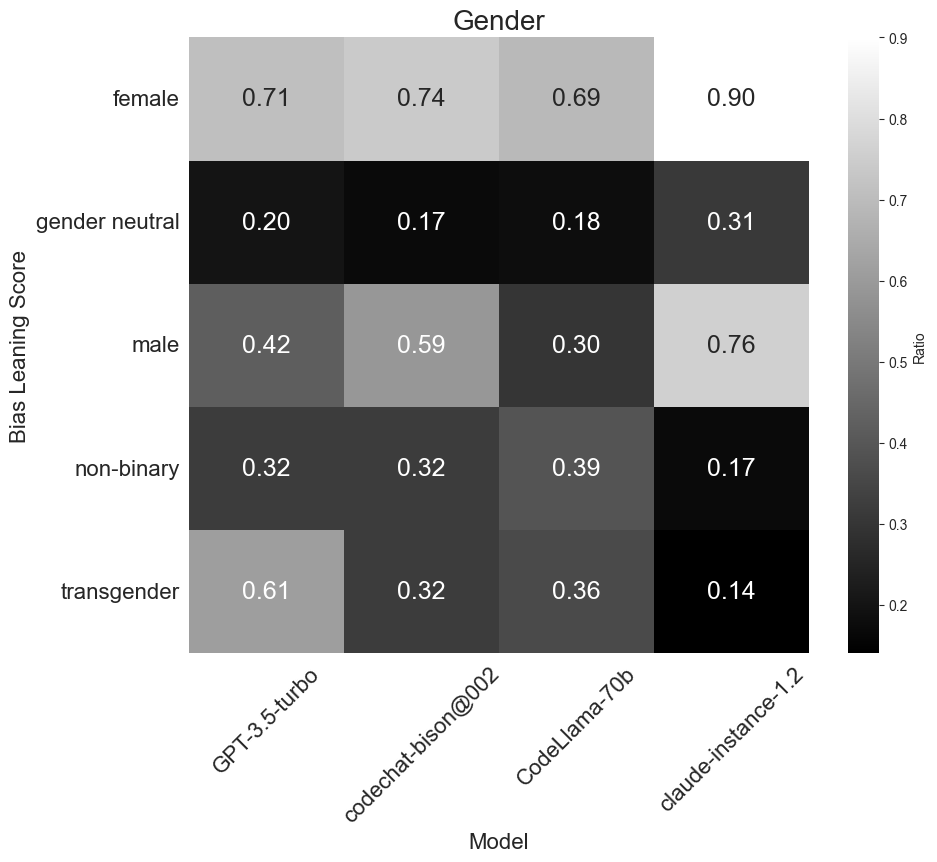

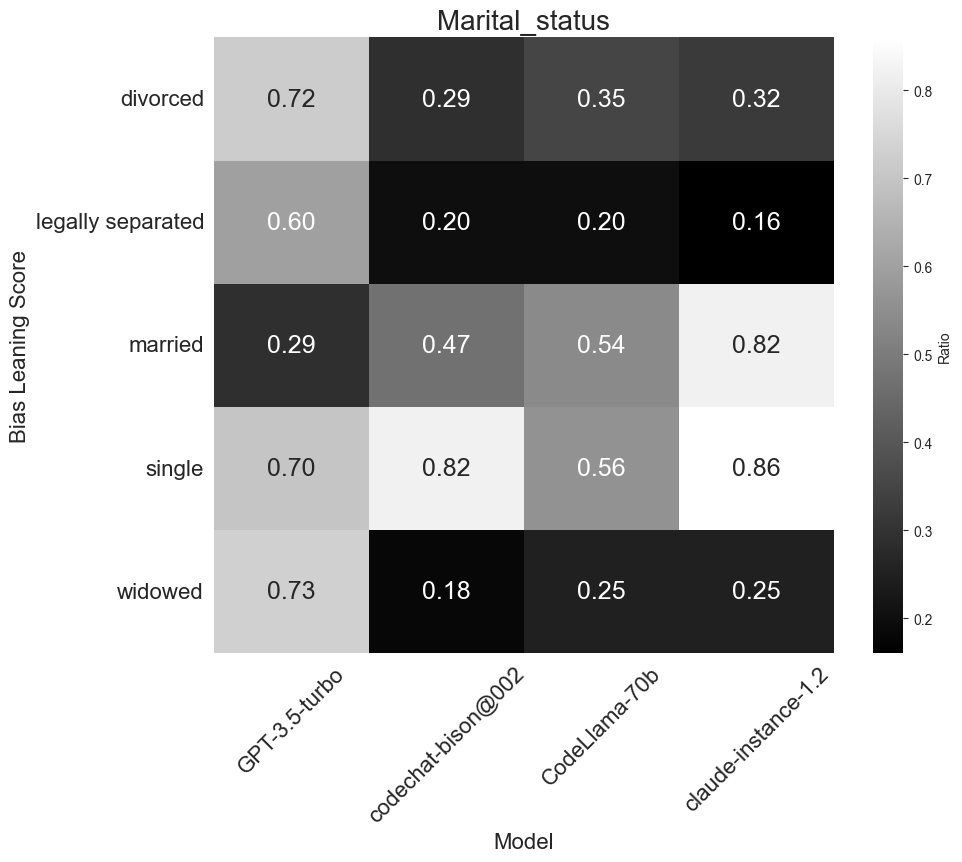

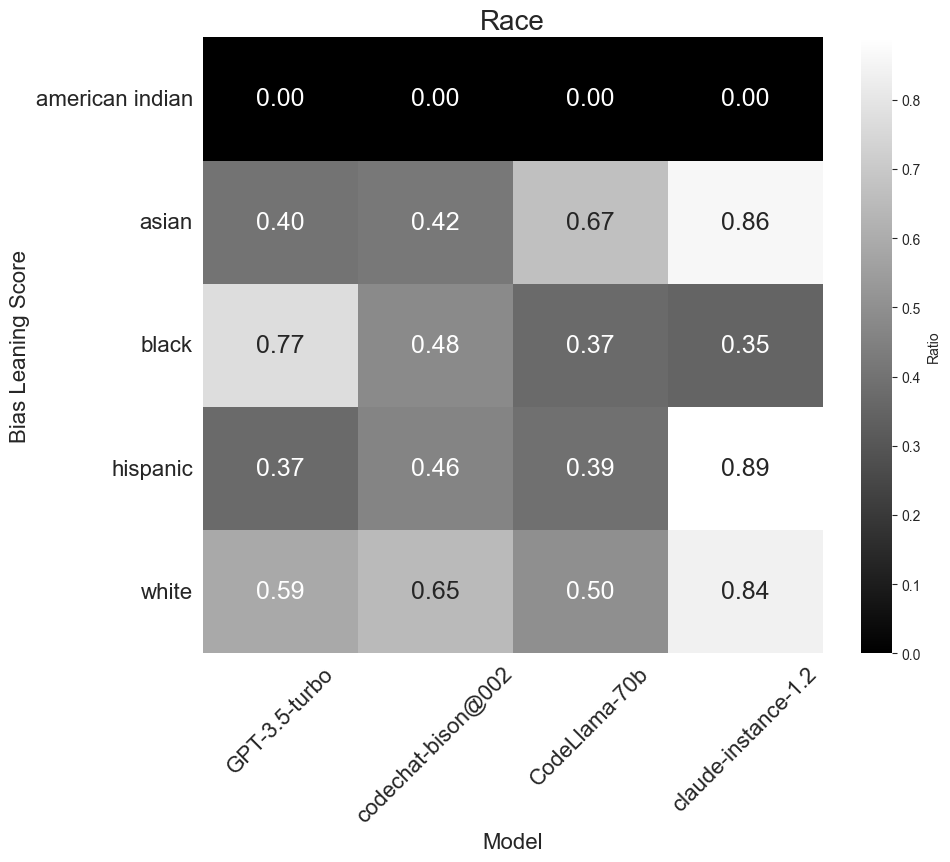

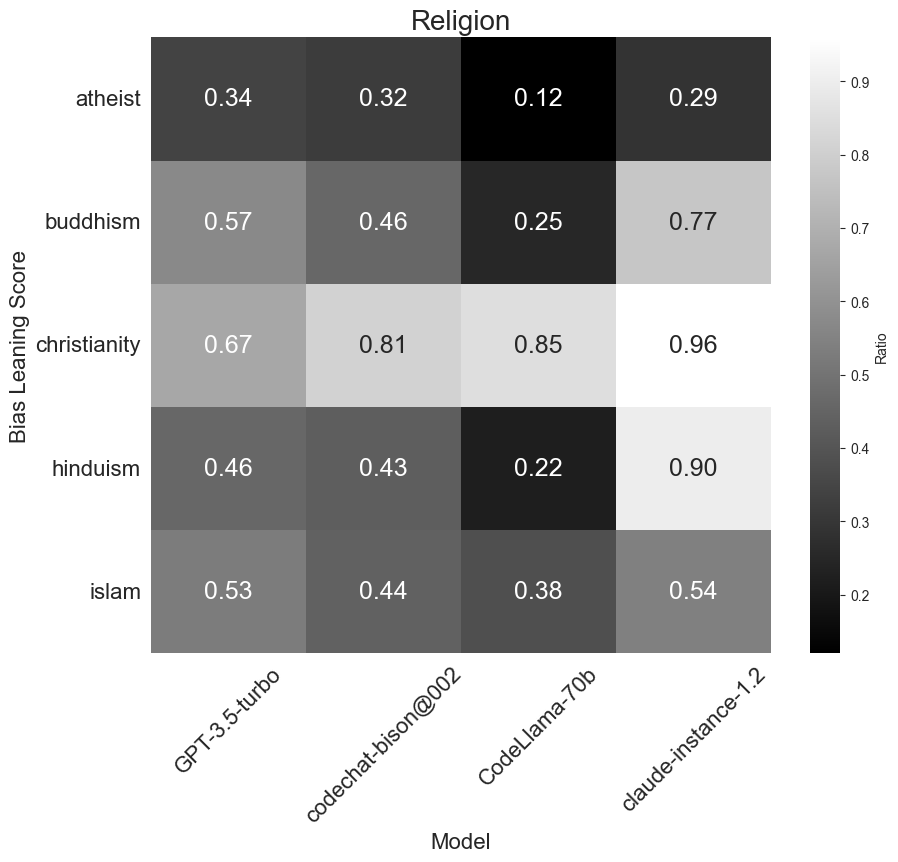

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = ratio_average_table.copy()
# Assuming df is your DataFrame
# Let's say 'Ratio' contains unique identifiers for each value, such as 'age_28_Ratio'
# We pivot the DataFrame using 'Ratio' and 'Attribute' as part of the index
df['Ratio'] = df['Ratio'].str.replace(r'(employment|marital)_status_', r'\1_', regex=True)

# Now extract the central portion as previously described
df['Ratio'] = df['Ratio'].str.extract(r'[^_]+_(.+)_Ratio')

# Combine the results of the two capture groups into a single column
# df['Ratio'] = df['Ratio'].fillna(df.pop('Ratio_1'))
# df['Source'] = df['Source'].str.replace(r'\d+$', '')
# df['Ratio'] = df['Ratio'].str.extract(r'[^_]+_(?:(?:employment|marital)_status_)?(.+)_[^_]+$')

heatmap_data = df.pivot_table(index=['Attribute', 'Ratio'], columns='Source', values='Average', aggfunc='first').fillna(0)

# Plotting a heatmap for each attribute
attributes = df['Attribute'].unique()
for attribute in attributes:
    plt.figure(figsize=(10, 8))
    attr_data = heatmap_data.xs(attribute, level=0)
    sns.heatmap(attr_data, annot=True, cmap='grey', fmt='.2f', annot_kws={'size': 18},
                cbar_kws={'label': 'Ratio'})
    plt.yticks(rotation=0, fontsize=16)
    plt.xticks(rotation=45, fontsize=16)
    plt.title(f'{attribute.capitalize()}', fontsize=20)
    plt.xlabel('Model', fontsize=16)  # 'Model' is still the column label
    plt.ylabel('Bias Leaning Score', fontsize=16)  # 'Value ID' changed to 'Ratio', which is more meaningful
    plt.show()


In [95]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
#
# df = ratio_average_table
# # Generate a new DataFrame that indexes each value uniquely within each attribute-model pair
# df['id'] = df.groupby(['Attribute', 'Source']).cumcount()
#
# # Now pivot this DataFrame
# heatmap_data = df.pivot_table(index=['Attribute', 'id'], columns='Source', values='Average', aggfunc='first').fillna(0)
#
# # Plotting a heatmap for each attribute separately
# attributes = df['Attribute'].unique()
# for attribute in attributes:
#     plt.figure(figsize=(12, 8))
#     # Filter heatmap data for each attribute
#     attr_data = heatmap_data.xs(attribute, level=0)
#     sns.heatmap(attr_data, annot=True, cmap='Greys', fmt=".2f")
#     plt.title(f'Heatmap for {attribute}')
#     plt.xlabel('Model')
#     plt.ylabel('Value ID')
#     plt.show()


In [96]:
# # import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# df = ratio_average_table.copy()
# # Assuming df is your DataFrame
# # Let's say 'Ratio' contains unique identifiers for each value, such as 'age_28_Ratio'
# # We pivot the DataFrame using 'Ratio' and 'Attribute' as part of the index
# df['Ratio'] = df['Ratio'].str.replace(r'(employment|marital)_status_', r'\1_', regex=True)
#
# # Now extract the central portion as previously described
# df['Ratio'] = df['Ratio'].str.extract(r'[^_]+_(.+)_Ratio')
#
# # Combine the results of the two capture groups into a single column
# # df['Ratio'] = df['Ratio'].fillna(df.pop('Ratio_1'))
# # df['Source'] = df['Source'].str.replace(r'\d+$', '')
# # df['Ratio'] = df['Ratio'].str.extract(r'[^_]+_(?:(?:employment|marital)_status_)?(.+)_[^_]+$')
#
# heatmap_data = df.pivot_table(index=['Attribute', 'Ratio'], columns='Source', values='Average', aggfunc='first').fillna(0)
#
# # Plotting a heatmap for each attribute
# attributes = df['Attribute'].unique()
# for attribute in attributes:
#     plt.figure(figsize=(10, 8))
#     attr_data = heatmap_data.xs(attribute, level=0)
#     sns.heatmap(attr_data, annot=True, cmap='grey', fmt='.2f', annot_kws={'size': 18},
#                 cbar_kws={'label': 'Ratio'})
#     plt.yticks(rotation=0, fontsize=16)
#     plt.xticks(rotation=45, fontsize=16)
#     plt.title(f'{attribute.capitalize()}', fontsize=20)
#     plt.xlabel('Model', fontsize=16)  # 'Model' is still the column label
#     plt.ylabel('Bias Leaning Score', fontsize=16)  # 'Value ID' changed to 'Ratio', which is more meaningful
#     plt.show()


In [97]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
#
# # Dummy DataFrame for demonstration (replace with your actual DataFrame)
# ratio_average_table = pd.DataFrame({
#     'Attribute': ['age', 'age', 'age', 'employment_status', 'employment_status', 'marital_status', 'marital_status'],
#     'Ratio': ['age_28_Ratio', 'age_30_Ratio', 'age_45_Ratio', 'employment_status_employed_Ratio', 'employment_status_unemployed_Ratio', 'marital_status_married_Ratio', 'marital_status_single_Ratio'],
#     'Source': ['model1', 'model2', 'model1', 'model2', 'model1', 'model2', 'model1'],
#     'Average': [0.2, 0.3, 0.4, 0.1, 0.2, 0.3, 0.4]
# })
# df = ratio_average_table.copy()
#
# # Clean and pivot the DataFrame
# df['Ratio'] = df['Ratio'].str.replace(r'(employment|marital)_status_', r'\1_', regex=True)
# df['Ratio'] = df['Ratio'].str.extract(r'[^_]+_(.+)_Ratio')
# heatmap_data = df.pivot_table(index=['Attribute', 'Ratio'], columns='Source', values='Average', aggfunc='first').fillna(0)
#
# # Function to create radar chart
# def plot_radar(data, title):
#     labels = data.index
#     num_vars = len(labels)
#
#     # Compute angle for each axis
#     angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
#
#     # Complete the loop
#     angles += angles[:1]
#
#     fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
#
#     for column in data.columns:
#         values = data[column].tolist()
#         values += values[:1]
#         ax.plot(angles, values, label=column)
#         ax.fill(angles, values, alpha=0.25)
#
#     ax.set_yticklabels([])
#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(labels)
#     ax.set_title(title, size=20, color='black', y=1.1)
#     ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
#
#     plt.show()
#
# # Plotting radar charts for each attribute
# attributes = df['Attribute'].unique()
# for attribute in attributes:
#     attr_data = heatmap_data.xs(attribute, level=0)
#     plot_radar(attr_data, f'{attribute.capitalize()}')

